<a href="https://colab.research.google.com/github/monu111/-Predict-product-purchased-or-not-using-Social_Network_ads/blob/master/Instacart_Market_Basket_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instacart Market Basket Analysis


# 1.  Objective:

- To predict which previously purchased products will be in a user’s next order.

- The goal predict which products will be in a user's next order. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users.

- For each user, 4 and 100 of their orders are given, with the sequence of products purchased in each order




##### Data set link : https://www.kaggle.com/c/instacart-market-basket-analysis/data



In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Step 1:Get you Kaggle API Token
Go to Your Account and click on Create New API Token.
A file named kaggle.json will get downloaded containing your username and token key

Step 2: Uploading kaggle.json into Google Drive

### 1.1 Run the following code to provide the config path to kaggle.json

In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Colab Notebooks/A"

# /content/gdrive/My Drive/A is the path where kaggle.json is present in the Google Drive

### Change your present working directory

In [5]:
#changing the working directory
%cd /content/gdrive/MyDrive/Colab Notebooks/A

# check the present working directory using pwd command

/content/gdrive/MyDrive/Colab Notebooks/A


In [6]:
!pwd # checking current working directory

/content/gdrive/MyDrive/Colab Notebooks/A


### 1.2 Download the kaggle dataset

 - Go to kaggle and copy the API Command to download the dataset

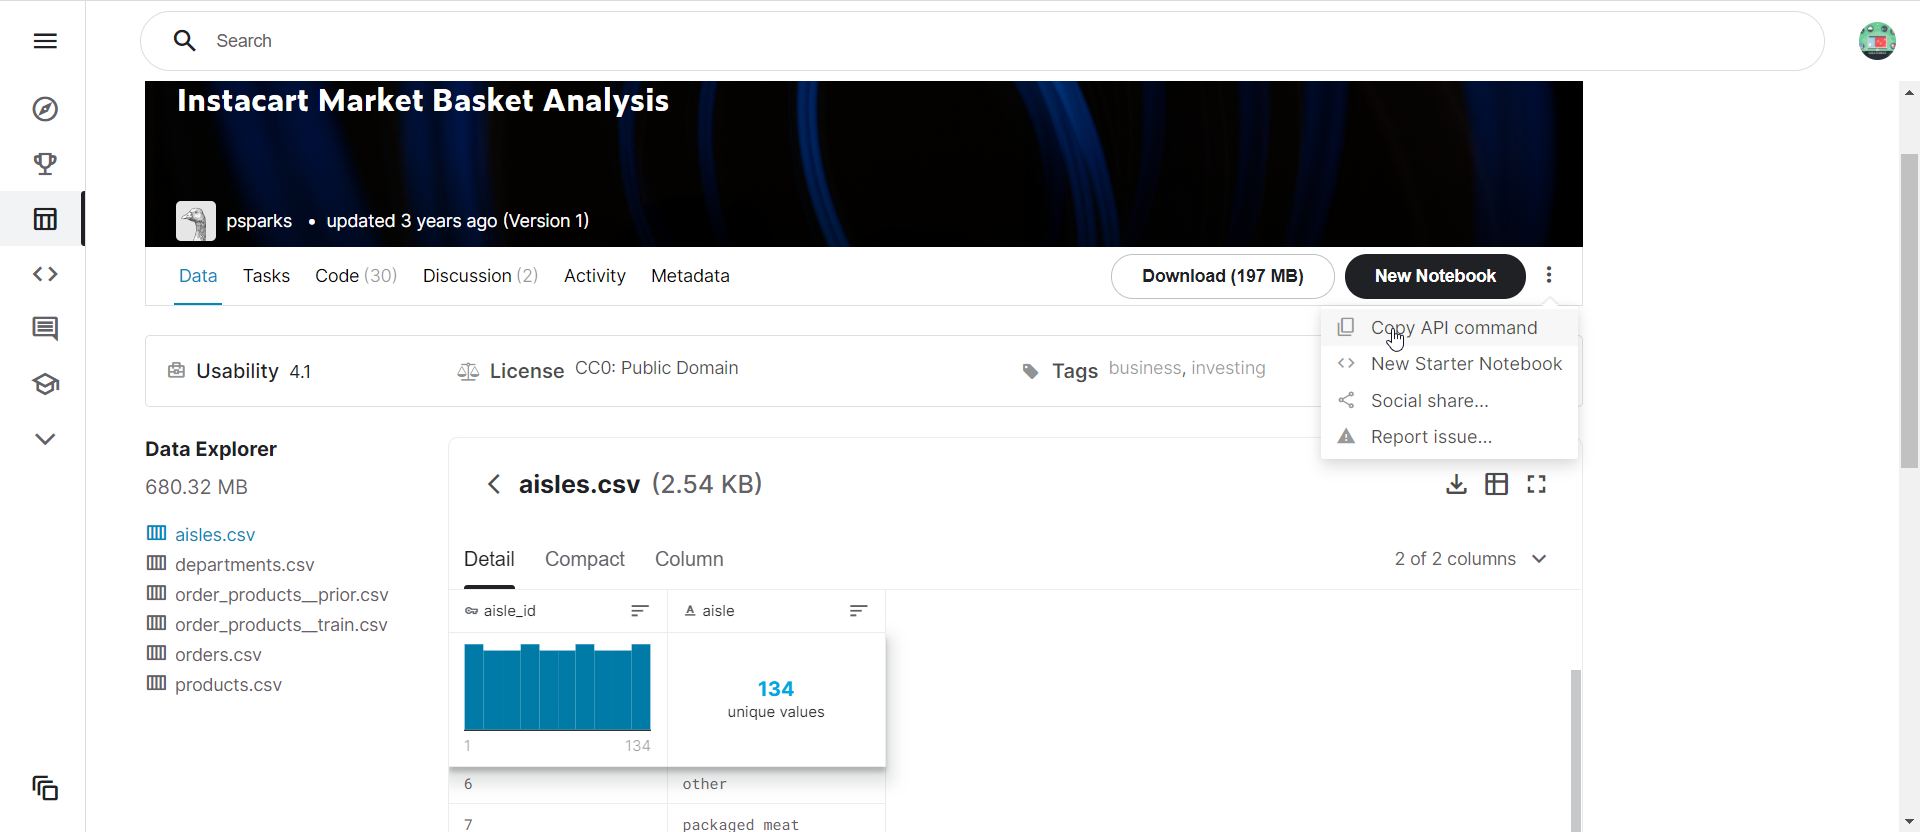

In [ ]:
!kaggle datasets download -d psparks/instacart-market-basket-analysis  # Downloading the data from kaggle to drive

 99% 196M/197M [00:02<00:00, 84.7MB/s]
100% 197M/197M [00:02<00:00, 90.3MB/s]


- Now our dataset is downloaded

### 1.3 Unzip your data and remove the zip file

In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Archive:  instacart-market-basket-analysis.zip
replace aisles.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# 2. Importing all necessary libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

import warnings
warnings.filterwarnings('ignore') #Supress unnecessary warnings for readability and cleaner presentation


In [8]:
from subprocess import check_output
print(check_output(["ls", "../A"]).decode("utf8"))

aisles.csv
departments.csv
Instacart Market Basket Analysis.ipynb
instacart-market-basket-analysis.zip
kaggle.json
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv
Untitled document.gdoc



- Before we dive deep into the exploratory analysis, let us know a little more about the files given. To understand it better, let us first read all the files as dataframe objects and then look at the top few rows.

## 3. Loading the dataset

In [9]:
order_products__train = pd.read_csv('order_products__train.csv')
order_products__prior = pd.read_csv('order_products__prior.csv')
order_df = pd.read_csv('orders.csv')
products_df = pd.read_csv('products.csv')
aisles_df = pd.read_csv('aisles.csv')
departments_df = pd.read_csv('departments.csv')

### 3.1 Checking the shape of datasets

In [10]:
print("Shape of order_products__train :", order_products__train.shape)
print("Shape of order_products__prior :", order_products__prior.shape)
print("Shape of order_df :", order_df.shape)
print("Shape of product_df :", products_df.shape)
print("Shape of aisles_df :", aisles_df.shape)
print("Shape of department_df :", departments_df.shape)



Shape of order_products__train : (1384617, 4)
Shape of order_products__prior : (32434489, 4)
Shape of order_df : (3421083, 7)
Shape of product_df : (49688, 4)
Shape of aisles_df : (134, 2)
Shape of department_df : (21, 2)


In [11]:
order_products__train.head() # 

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [12]:
order_products__prior.head() #

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [13]:
order_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [14]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [15]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [16]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


As we could see, orders.csv has all the information about the given order id like the user who has purchased the order, when was it purchased, days since prior order and so on.

The columns present in order_products_train and order_products_prior are same. Then what is the difference between these files.?

As mentioned earlier, in this dataset, 4 to 100 orders of a customer are given (we will look at this later) and we need to predict the products that will be re-ordered. So the last order of the user has been taken out and divided into train and test sets. All the prior order informations of the customer are present in order_products_prior file. We can also note that there is a column in orders.csv file called eval_set which tells us as to which of the three datasets (prior, train or test) the given row goes to.

Order_products*csv file has more detailed information about the products that been bought in the given order along with the re-ordered status.

Let us first get the count of rows in each of the three sets.

##  4. Data analysis  

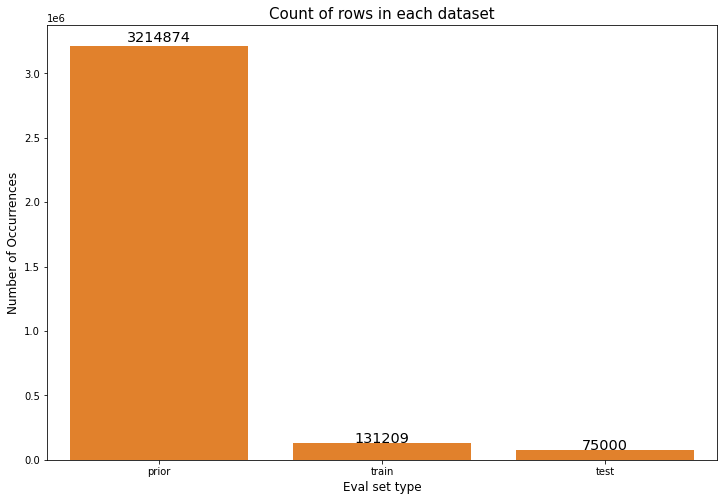

In [17]:
cnt_srs = order_df.eval_set.value_counts()
plt.figure(figsize=(12,8))
ax = sns.barplot(x = cnt_srs.index, y = cnt_srs.values, color = color[1])

for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy() 
    ax.annotate(f'{round(height)}', (x + width/2, y + height*1.01), ha='center', fontsize = 'x-large')

plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
#plt.xticks(rotation='vertical')
plt.show()

In [18]:
def get_unique_count(x):
  return len(np.unique(x))
cnt_srs = order_df.groupby('eval_set')['user_id'].aggregate(get_unique_count)
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

__Insights:__
- So there are 206,209 customers in total. Out of which, the last purchase of 131,209 customers are given as train set and we need to predict for the rest 75,000 customers.


- Now let us validate the claim that 4 to 100 orders of a customer are given

### 4.2  Validate the claim that 4 to 100 orders of a customer are given or not

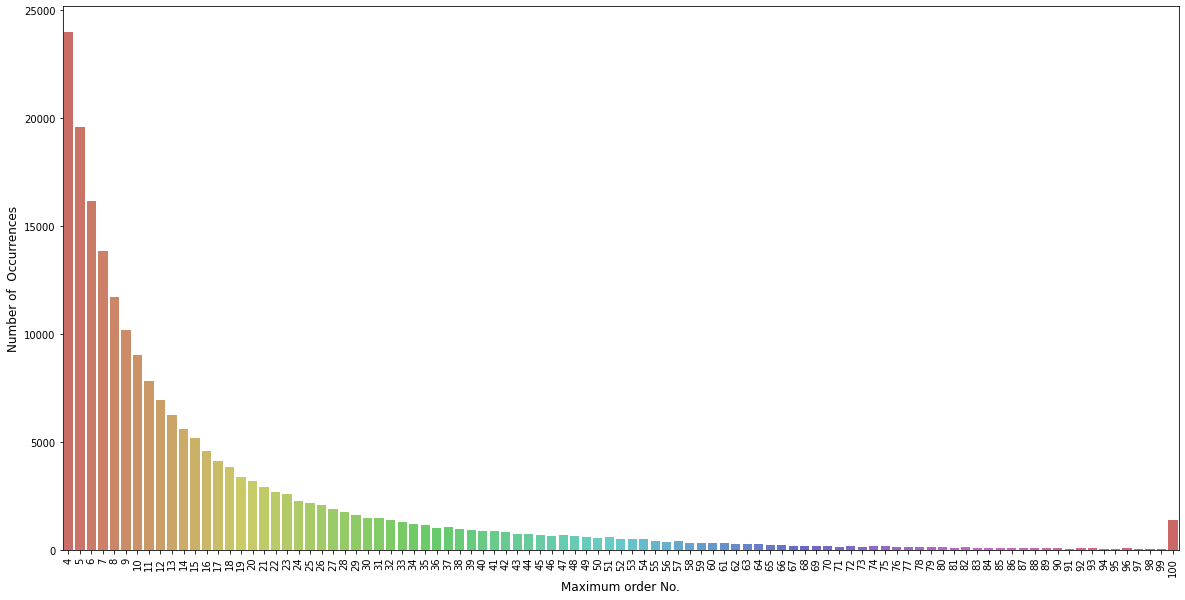

In [19]:
cnt_srs = order_df.groupby('user_id')['order_number'].aggregate(np.max).reset_index()

cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize = (20,10))
sns.barplot(x = cnt_srs.index, y = cnt_srs, palette = 'hls')
plt.xticks(rotation  = 90)


plt.xlabel('Maximum order No.', fontsize = 12)
plt.ylabel('Number of  Occurrences', fontsize = 12)
plt.show()

__Insights:__
- So there are no order less than 4 and is max capped at 100 as given in the data page.
-  As above we can see that, Less orders by the  customers have high number occurrences.

- The maximium orders by customer is 100 and minimum order by customer is 4.

### 4.3 Frequency of order by week day

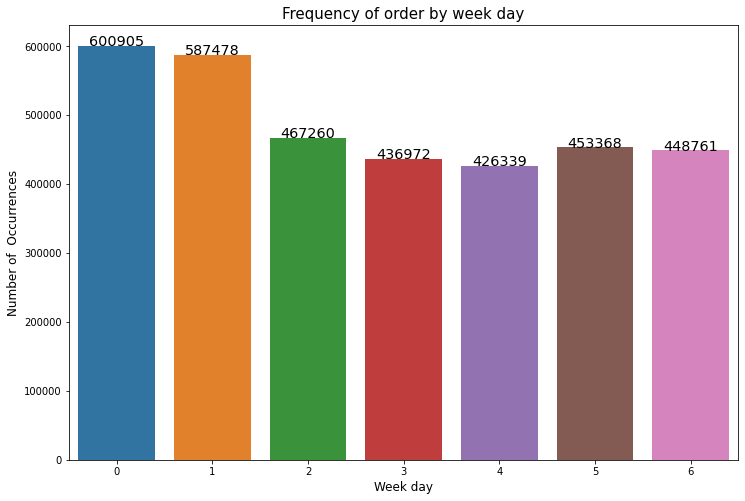

In [20]:
cnt_srs = order_df.order_dow.value_counts()
plt.figure(figsize = (12,8))
ax = sns.barplot(x = cnt_srs.index, y = cnt_srs)

## annotation on bars
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy() 
    ax.annotate(f'{round(height)}', (x + width/2, y + height), ha='center', fontsize = 'x-large')

plt.title('Frequency of order by week day', fontsize = 15)
plt.xlabel('Week day', fontsize = 12)
plt.ylabel('Number of  Occurrences', fontsize = 12)
plt.show()

__Insights:__
- from above we can see, 0 and 1th day order are high. seems like saturday and sunday.
- And the  4th day order is less compare to the other days.


### 4.4 Distribution w.r.t to hour of day

- Let see the distribution with respect to the order_hour_of_day

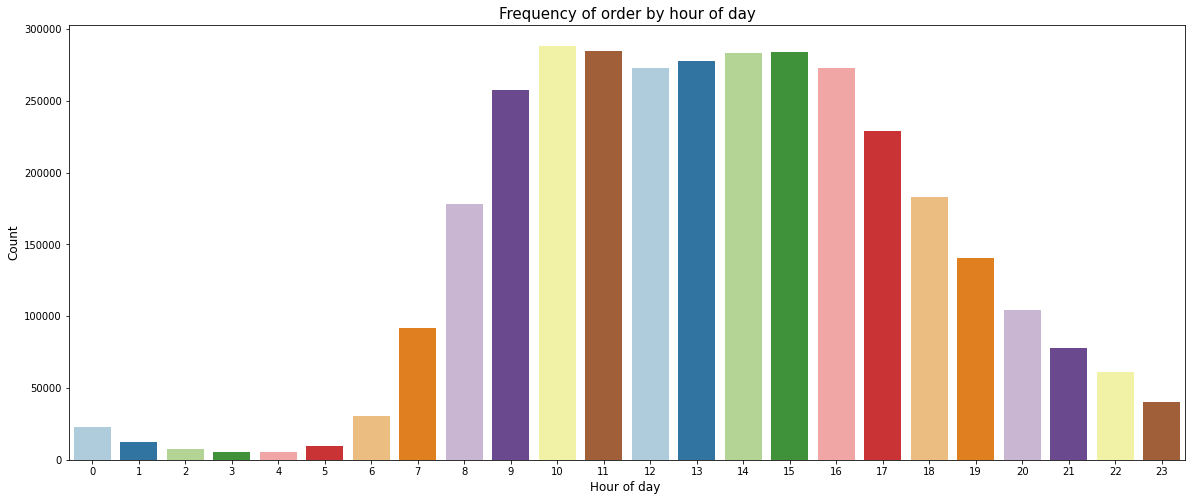

In [21]:
plt.figure(figsize = (20,8))
ax = sns.countplot(x = 'order_hour_of_day', data = order_df, palette  = 'Paired')

plt.title('Frequency of order by hour of day', fontsize = 15)
plt.xlabel('Hour of day ', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.show()


__Insights:__

- So majority of the order made by daytime(8 to 18)

### 4.5 Frequency of day of week Vs Hour day

- Combine the day of week and hour of day to see the distribution.

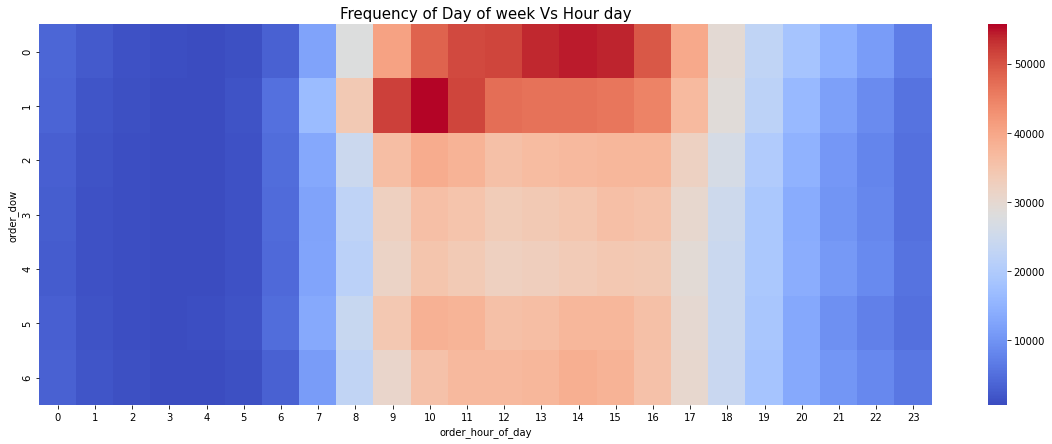

In [22]:
grp_df = order_df.groupby(['order_dow', 'order_hour_of_day'])['order_number'].aggregate("count").reset_index()

group_df = grp_df.pivot('order_dow', 'order_hour_of_day','order_number')

plt.figure(figsize=  (20,7))
sns.heatmap(group_df,cmap = 'coolwarm', linewidths= .0001)

plt.title('Frequency of Day of week Vs Hour day', fontsize = 15)
plt.show()


__Insights:__
- Seems like , (0) evenning and (1) morning are the prime time of order.

### 4.6 Frequency of distribution by days since prior order
- Time intervals between the orders.

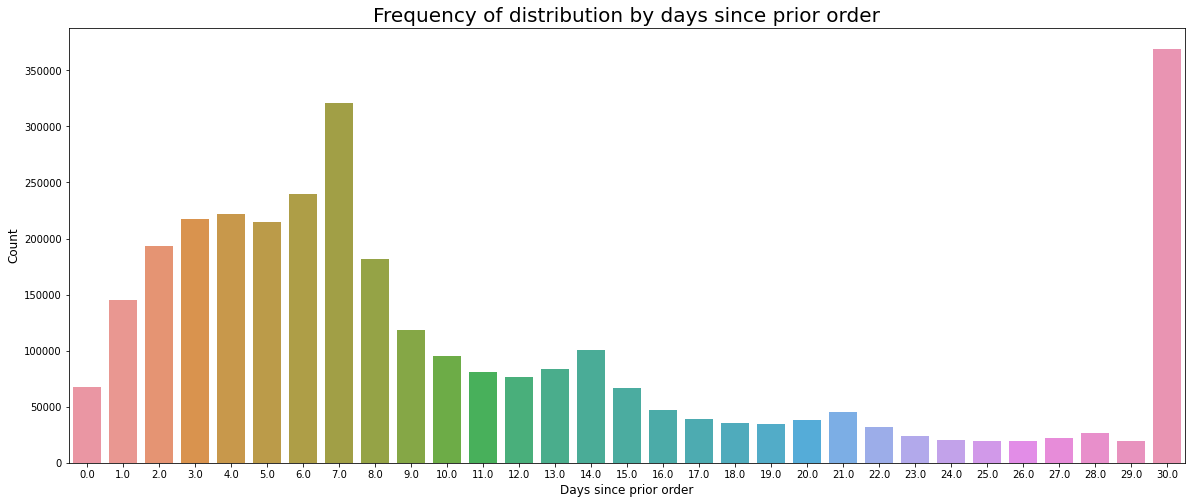

In [23]:
plt.figure(figsize = (20,8))
ax = sns.countplot(x = 'days_since_prior_order', data = order_df)

plt.title('Frequency of distribution by days since prior order', fontsize = 20)
plt.xlabel('Days since prior order', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.show()

__Insights:__
- From above we can see that, customer order once in every week day(see peak at 7.0) or once in month (peak at 30.0).
- We could also see smaller peaks at 14, 21 and 28 days (weekly intervals).

- Our objective is to figure out the re-orders, let us check out the re-order percentage in prior set and train set.

### 4.7 percentage of re-orders in prior set & train set #


In [24]:
# percent of re-order in prior set

order_products__prior.reordered.sum()/order_products__prior.shape[0]

0.5896974667922161

In [25]:
# percent of re-order in  train set

order_products__train.reordered.sum()/order_products__train.shape[0]

0.5985944127509629

- On an average 59% of the products in an order are re-ordered products.

### 4.8 No re-ordered products

- **` Let see, when none of the product are reordered`**

In [26]:
grp_df = order_products__prior.groupby('order_id')['reordered'].aggregate('sum').reset_index()
grp_df["reordered"].loc[grp_df["reordered"]>1] = 1  # reoreded greater than 1 become 1 & apart  from them  is 0
grp_df.reordered.value_counts()/grp_df.shape[0] #

1    0.879151
0    0.120849
Name: reordered, dtype: float64

In [27]:
grp_df = order_products__train.groupby('order_id')['reordered'].aggregate('sum').reset_index()

grp_df['reordered'].loc[grp_df['reordered']>1] = 1

grp_df.reordered.value_counts()/grp_df.shape[0]

1    0.93444
0    0.06556
Name: reordered, dtype: float64

__Insights:__
- About 12% orders in prior has no reordered items while in the train set it is 6.5%.

### 4.9 Now concatenating  the order_products_train and order_products_prior.

In [28]:
order_products_all = pd.concat([order_products__prior, order_products__train], axis = 0)


print('Shape after concatenating :', order_products_all.shape)
print('Shape of order_products__train before  concatenating :', order_products__train.shape)
print('Shape of order_products_prior before concatenating :', order_products__prior.shape)

Shape after concatenating : (33819106, 4)
Shape of order_products__train before  concatenating : (1384617, 4)
Shape of order_products_prior before concatenating : (32434489, 4)


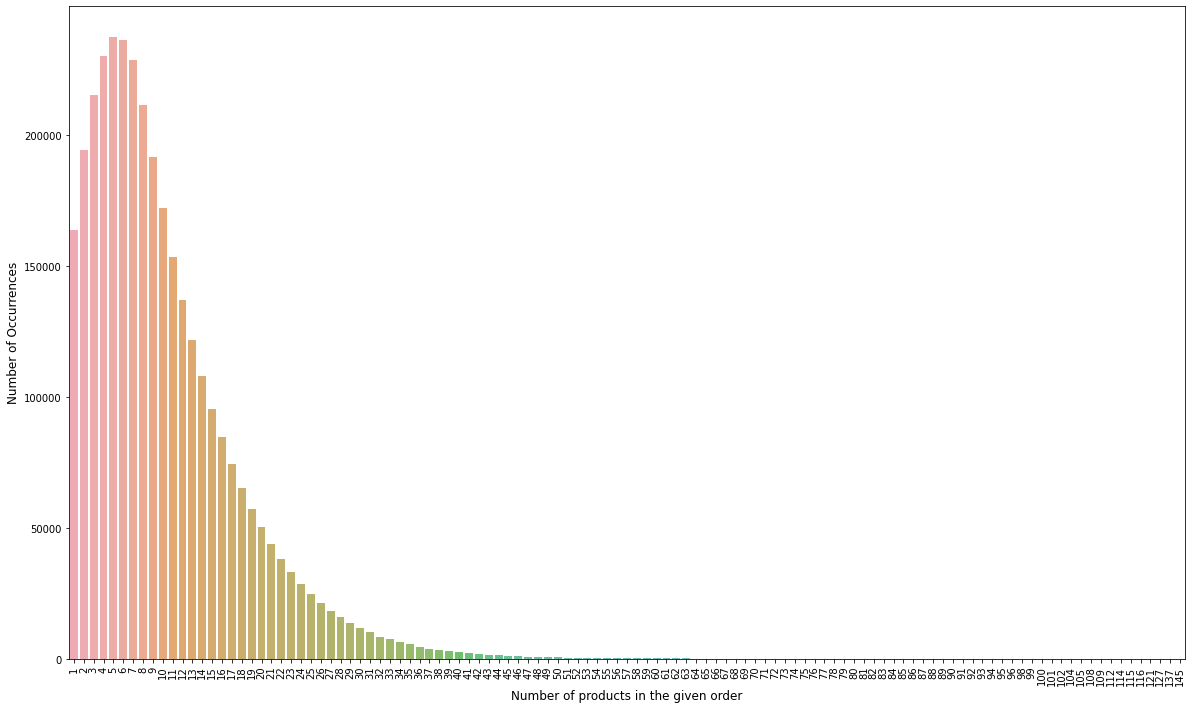

In [29]:
grouped_df = order_products_all.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(20,12))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

__Insights:__
- Right tale distribution maximum at 5.

### 4.10 Merging order_products_all , aisles_df & departments_df,

In [30]:
order_product_all_mrgd = pd.merge(order_products_all, products_df, on = 'product_id', how = 'left') #

In [31]:
order_product_all_mrgd = pd.merge(order_product_all_mrgd, aisles_df , on = 'aisle_id', how = 'left') #

In [32]:
order_product_all_mrgd = pd.merge(order_product_all_mrgd, departments_df, on = 'department_id', how = 'left') # 

order_product_all_mrgd.head()


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


In [33]:
cnt_srs = order_product_all_mrgd['aisle'].value_counts().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

fresh fruits                     3792661
fresh vegetables                 3568630
packaged vegetables fruits       1843806
yogurt                           1507583
packaged cheese                  1021462
milk                              923659
water seltzer sparkling water     878150
chips pretzels                    753739
soy lactosefree                   664493
bread                             608469
refrigerated                      599109
frozen produce                    545107
ice cream ice                     521101
crackers                          478430
energy granola bars               473835
eggs                              472009
lunch meat                        412087
frozen meals                      408520
baby food formula                 395654
fresh herbs                       393793
Name: aisle, dtype: int64

- Most of them are organic products.! Also majority of them are fruits.

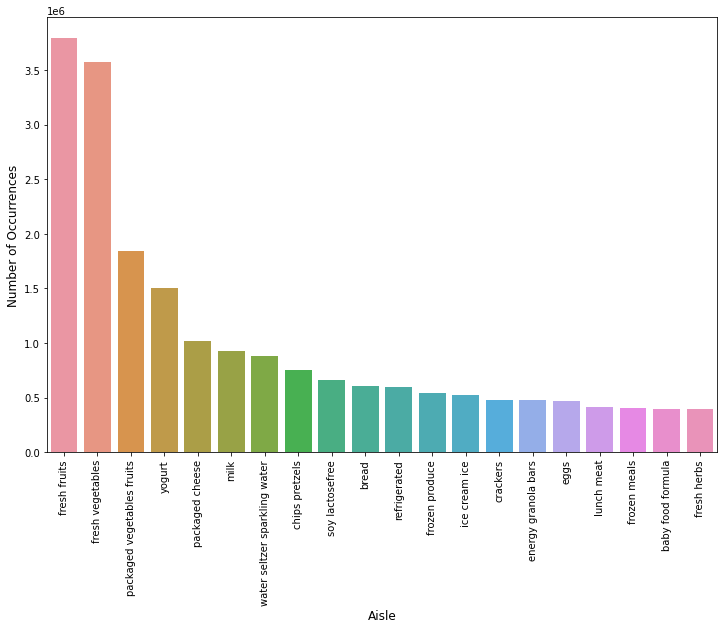

In [34]:
cnt_srs = order_product_all_mrgd['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(x = cnt_srs.index, y = cnt_srs)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation= 90)
plt.show()

- The top two Aisle are fresh fruits and fresh vegitables.

### 4.11 Departments Distribution:

- Let us know check the department wise distribution.

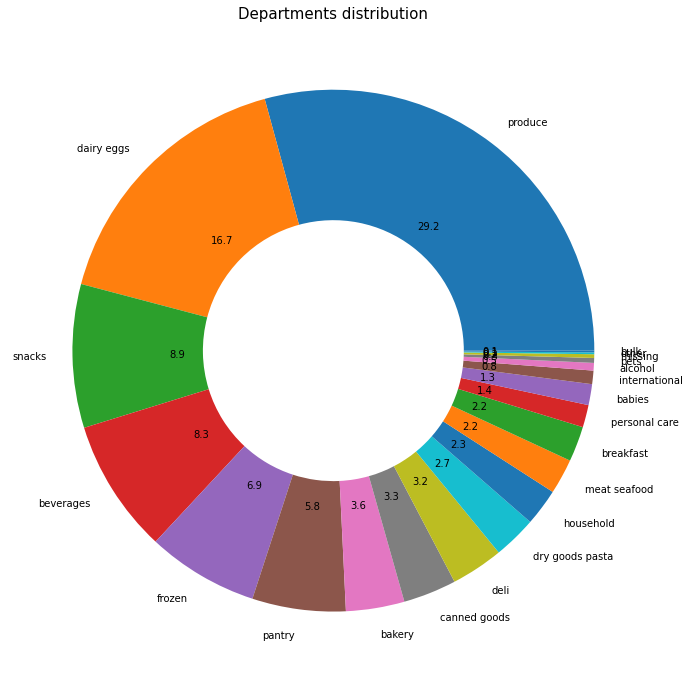

In [35]:
plt.figure(figsize = (12,12))
v = order_product_all_mrgd['department'].value_counts()
labels = (np.array(v.index))

plt.pie(v, wedgeprops = dict(width = 0.5), labels = labels, autopct=  '%0.01f')
plt.title("Departments distribution", fontsize=15)
plt.show()

__Insights:__
- Produce is the largest department.

### 4.12 Department wise reorder ratio

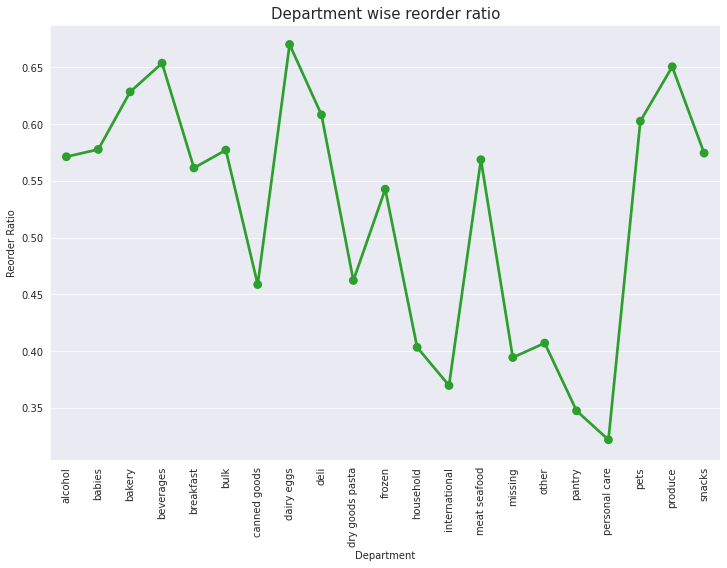

In [36]:
grp = order_product_all_mrgd.groupby(['department'])['reordered'].aggregate('mean').reset_index()
sns.set_style('darkgrid')
plt.figure(figsize = (12,8))

sns.pointplot(grp['department'], grp['reordered'], color = color[2])
plt.xticks(rotation = 90)
plt.title('Department wise reorder ratio', fontsize = 15)
plt.ylabel('Reorder Ratio')
plt.xlabel('Department')
plt.show()

__Insights:__
- Personal care has lowest reorder and dairy egg have higest reorder ratio.

### 4.13 Aisle- Reorder ratio:

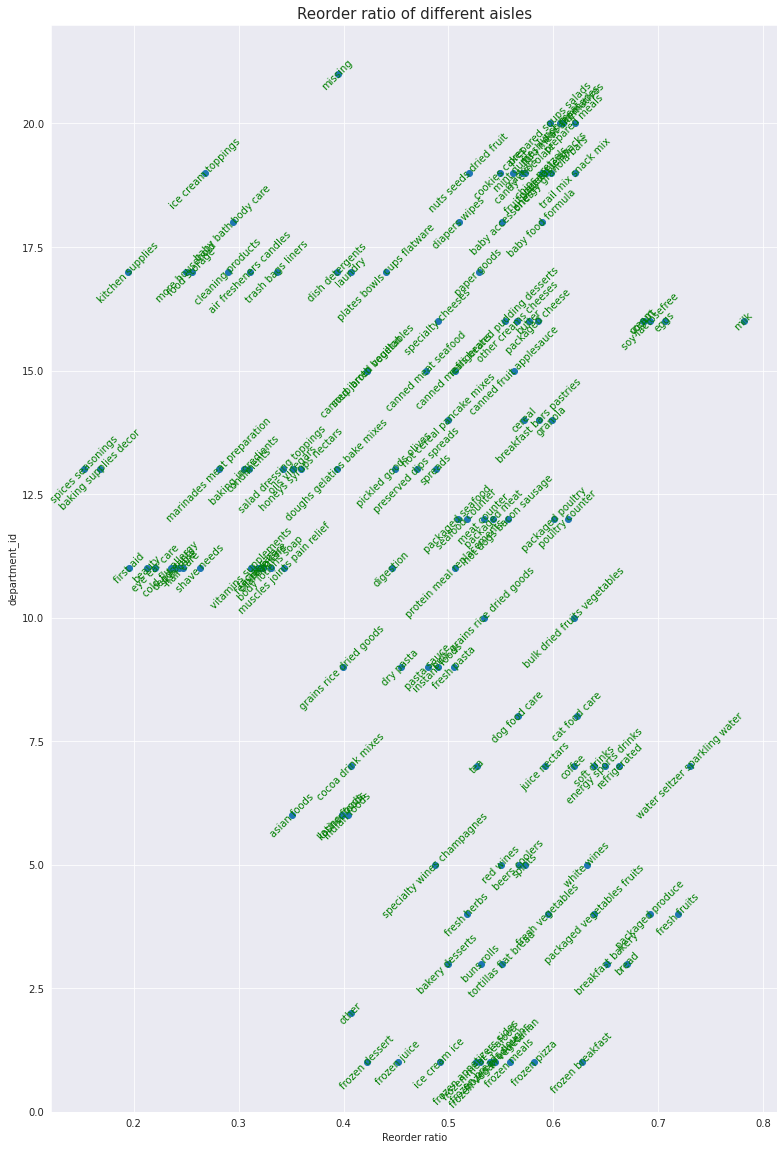

In [37]:
grp = order_product_all_mrgd.groupby(['department_id','aisle'])['reordered'].agg('mean').reset_index()
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=  (13,20))
ax.scatter(grp.reordered.values, grp.department_id.values)

for i,txt in enumerate(grp.aisle.values):
  ax.annotate(txt, (grp.reordered.values[i], grp.department_id.values[i]), rotation = 45, ha = 'center', va = 'center', color = 'green')

plt.xlabel('Reorder ratio')
plt.ylabel('department_id')
plt.title("Reorder ratio of different aisles", fontsize=15)
plt.show()

### 4.14 add to cart reordered ratio

- Now lets explore how order of adding the product to the cart affects the reroder ratio.

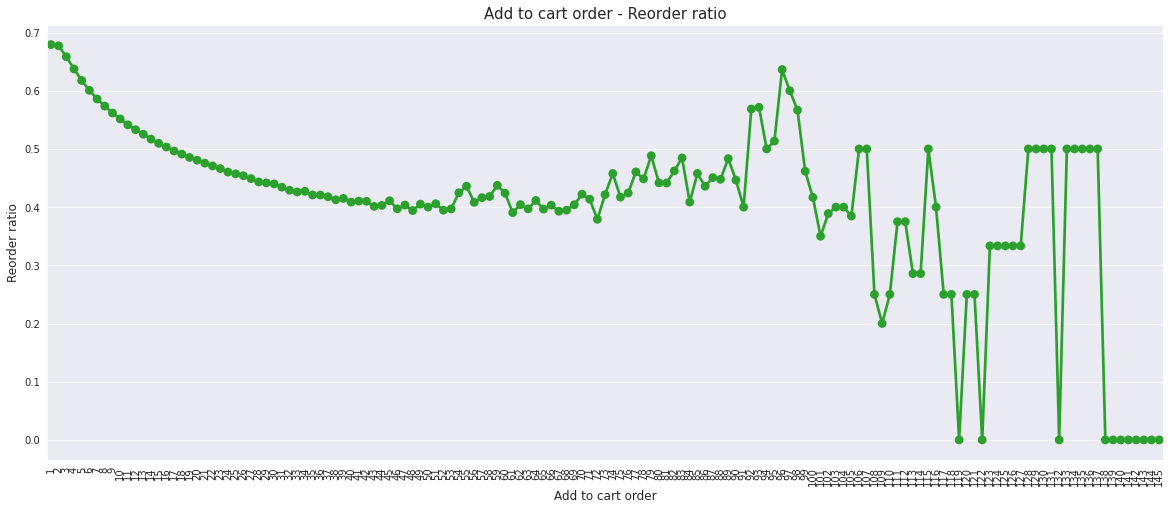

In [38]:
grp = order_product_all_mrgd.groupby('add_to_cart_order')['reordered'].agg('mean').reset_index()

plt.figure(figsize = (20, 8))
sns.pointplot(grp['add_to_cart_order'].values, grp['reordered'].values, color = color[2])
plt.xticks(rotation = 90)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xlabel('Add to cart order', fontsize=12)
plt.ylabel('Reorder ratio', fontsize=12)
plt.show()

__Insights:__
- Looks like the products that are added to the cart intially are more likely to be reordered again compared to the ones added later.

### 4.15 Reorder ratio across day of week

---



In [39]:
# merging order_df to get reordered_ratio based on week, hour of the day
order_product_all_mrgd1 = pd.merge(order_product_all_mrgd, order_df, on = 'order_id', how = 'left') 


In [40]:
order_product_all_mrgd1.head(n= 2)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0


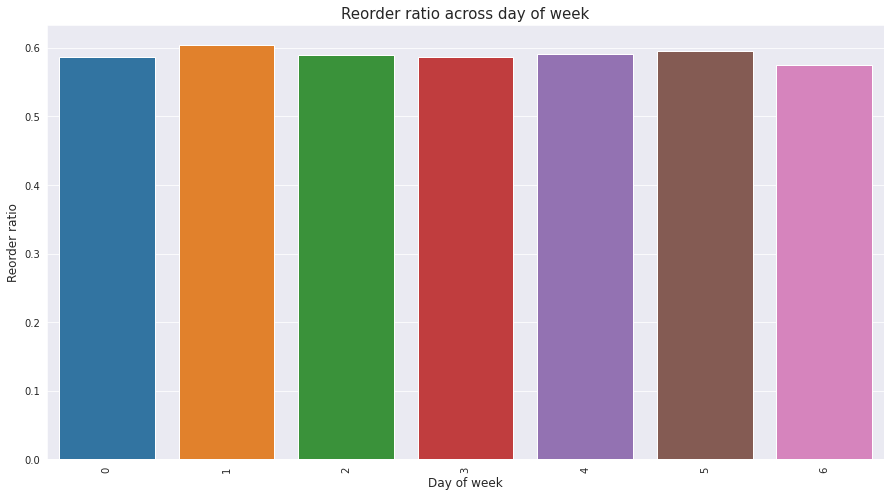

In [41]:
grp = order_product_all_mrgd1.groupby('order_dow')['reordered'].agg('mean').reset_index()
plt.figure(figsize = (15,8))

sns.barplot(grp['order_dow'].values, grp['reordered'].values)

plt.title("Reorder ratio across day of week", fontsize=15)
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)

plt.xticks(rotation='vertical')
plt.show()

### 4.16 Reorder ratio across hour of the day

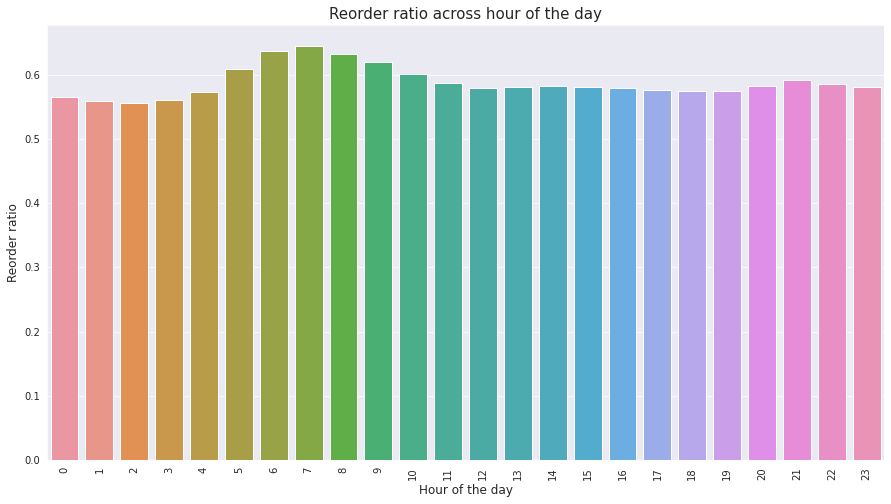

In [49]:
grp = order_product_all_mrgd1.groupby('order_hour_of_day')['reordered'].agg('mean').reset_index()
plt.figure(figsize = (15,8))

sns.barplot(grp['order_hour_of_day'].values, grp['reordered'].values)

plt.title("Reorder ratio across hour of the day", fontsize=15)
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of the day', fontsize=12)

plt.xticks(rotation='vertical')
plt.show()

### 4.17 Reorder ratio of Day of week Vs Hour of day

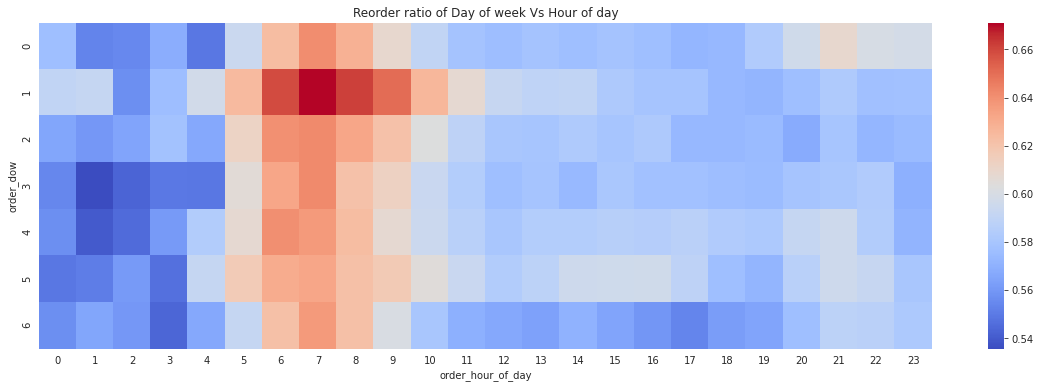

In [50]:
grp = order_product_all_mrgd1.groupby(['order_dow', 'order_hour_of_day'])['reordered'].agg('mean').reset_index()

grp_df = grp.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize = (20,6))
sns.heatmap(grp_df, cmap = 'coolwarm')
plt.title('Reorder ratio of Day of week Vs Hour of day')
plt.show()

__Insights:__

- Looks like reorder ratios are quite high during the early mornings compared to later half of the day.

# Conclusion :
**`1. Initially data was segregated & data divided in 6 part which was Order_products__train, order_products__prior, order_df, products_df, aisles_df, departments_df.`**

**`2. There are 206,209 customers in total. Out of which, the last purchase of 131,209 customers are given as train set and we need to predict for the rest 75,000 customers  [in order_df data].`**


**`3. there are no order less than 4 and is max capped at 100 & less orders by the  customers have high number occurrences..`**


**`4. From the observation , 0 and 1th day order are high. seems like saturday and sunday and the  4th day order is less compare to the other days.`**


**`5. From the observation, majority of the order made by daytime(8 to 18)`**

**`6. From the analysis, (0) evenning and (1) morning are the prime time of order.`**

**`7. From the analysis, customer order once in every week day(see peak at 7.0) or once in month (peak at 30.0) & we could also see smaller peaks at 14, 21 and 28 days (weekly intervals). .`**

**`8. From the analysis, on an average 59% of the products in an order are re-ordered products.`**


**`9. From the analysis, most of them are organic products.! Also majority of them are fruits.`**

**`10. From the analysis,  top two Aisle are fresh fruits and fresh vegitables.`**


**`11. From the analysis,  produce & dairy farm is the largest department `**

**`12. From the analysis, Personal care has lowest reorder and dairy egg have higest reorder ratio.`**

**`13. From the analysis, the products that are added to the cart intially are more likely to be reordered again compared to the ones added later.`**

**`14. From the analysis ,reorder reorder ratio was quite high during the early mornings compared to later half of the day.`**

